### Creating and publishing a hugging face dataset with references to anndata files. 

Can for example be used to train multimodal models with mmcontext. The datasets consist of a reference to a sample of an anndata file,
which can be stored locally or remotly on nextcloud. 

Use the initial embedder to include some initial embeddings into our anndata object which can then be used later.

In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
from adata_hf_datasets.utils import setup_logging

setup_logging()

<RootLogger root (INFO)>

In [ ]:
import anndata

data_name = "cellxgene_pseudo_bulk_35k"
adata = anndata.read_h5ad(f"../data/RNA/processed/train/{data_name}/train.h5ad")
# adata = anndata.read_h5ad("../data/RNA/raw/test/tabula_sapiens_bone_marrow.h5ad")

In [58]:
# subset to 1000 genes
adata_sub = adata[:200, :1000]

In [62]:
del adata_sub.obsp
del adata_sub.obsm
del adata_sub.layers
del adata_sub.uns
del adata_sub.varm

In [47]:
del adata_sub.var

In [64]:
adata_sub.write_h5ad("../data/demo/demo.h5ad")

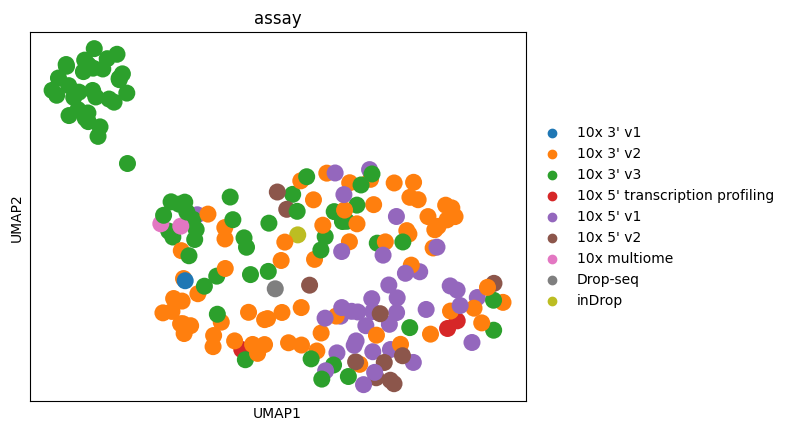

In [ ]:
import scanpy as sc

batch_key = "assay"
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=batch_key)

In [48]:
adata.obs["natural_language_annotation"]
caption_key = "natural_language_annotation"

In [49]:
# Delete objects that are not needed and are taking up space
del adata.obsm["natural_language_annotation_replicates"]
del adata.layers

In [63]:
from adata_hf_datasets.initial_embedder import InitialEmbedder

adata.layers["counts"] = adata.X
methods = ["hvg", "pca", "scvi", "geneformer"]
for method in methods:
    embedder = InitialEmbedder(method=method)
    embedder.fit(adata, batch_key=batch_key)
    adata = embedder.embed(adata)

2025-02-11 12:49:58,601 - adata_hf_datasets.initial_embedder - INFO - Fitting method 'hvg' with embedding_dim=64
2025-02-11 12:49:58,601 - adata_hf_datasets.initial_embedder - INFO - Normalizing and log-transforming data before HVG selection.
2025-02-11 12:49:58,608 - adata_hf_datasets.initial_embedder - INFO - Selecting top 2000 highly variable genes.
2025-02-11 12:49:58,619 - adata_hf_datasets.initial_embedder - INFO - Successfully identified highly variable genes.
2025-02-11 12:49:58,620 - adata_hf_datasets.initial_embedder - INFO - Embedding data using method hvg. Storing embeddings in X_hvg.
2025-02-11 12:49:58,626 - adata_hf_datasets.initial_embedder - INFO - Stored highly variable gene expression in adata.obsm[X_hvg]
2025-02-11 12:49:58,627 - adata_hf_datasets.initial_embedder - INFO - Fitting method 'pca' with embedding_dim=64
2025-02-11 12:49:58,627 - adata_hf_datasets.initial_embedder - INFO - Fitting PCA with 64 components.
2025-02-11 12:49:58,628 - adata_hf_datasets.initial

2025-02-11 12:49:59,038 - adata_hf_datasets.initial_embedder - INFO - Embedding data using method pca. Storing embeddings in X_pca.
2025-02-11 12:49:59,051 - adata_hf_datasets.initial_embedder - INFO - Fitting method 'scvi' with embedding_dim=64
2025-02-11 12:49:59,053 - adata_hf_datasets.initial_embedder - INFO - Setting up scVI model with embedding_dim=64
/Users/mengerj/repos/adata_hf_datasets/.venv/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:186: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(
2025-02-11 12:49:59,120 - adata_hf_datasets.initial_embedder - INFO - Training scVI model.
/Users/mengerj/repos/adata_hf_datasets/.venv/lib/python3.12/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train functio

Training:   0%|          | 0/10 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
2025-02-11 12:50:00,718 - lightning.pytorch.utilities.rank_zero - INFO - `Trainer.fit` stopped: `max_epochs=10` reached.
2025-02-11 12:50:00,722 - adata_hf_datasets.initial_embedder - INFO - Embedding data using method scvi. Storing embeddings in X_scvi.
2025-02-11 12:50:00,733 - adata_hf_datasets.initial_embedder - INFO - Setting up an Geneformer model with model_input_size=4096
2025-02-11 12:50:00,734 - adata_hf_datasets.initial_embedder - INFO - Fitting method 'geneformer' with embedding_dim=64
2025-02-11 12:50:00,734 - root - INFO - Geneformer model is pretrained and does not require fitting.
2025-02-11 12:50:00,734 - adata_hf_datasets.initial_embedder - INFO - Embedding data using method geneformer. Storing embeddings in X_geneformer.
2025-02-11 12:50:00,735 - adata_hf_datasets.utils - INFO - Gene symbols are exptected to be found in .var_names. An example gene symbol: ENSG00000000003
2025-02-11 12:50:00,736 - adata_hf_datasets

  0%|          | 0/13 [00:00<?, ?it/s]

In [64]:
from adata_hf_datasets.utils import split_anndata
import os
from pathlib import Path

project_dir = Path().resolve().parents[0]
train_path = f"{project_dir}/data/RNA/processed/train/{data_name}.h5ad"
val_path = f"{project_dir}/data/RNA/processed/val/{data_name}.h5ad"
os.makedirs(os.path.dirname(train_path), exist_ok=True)
os.makedirs(os.path.dirname(val_path), exist_ok=True)
train_data, val_adata = split_anndata(adata, train_size=0.9)
train_data.write(train_path)
val_adata.write(val_path)

In [65]:
train_remote_path = f"datasets/train/{data_name}.h5ad"
val_remote_path = f"datasets/val/{data_name}.h5ad"

In [65]:
from dotenv import load_dotenv

load_dotenv(override=True)
nextcloud_config = {
    "url": "NEXTCLOUD_URL",
    "username": "NEXTCLOUD_USER",  # env will we obtained within code
    "password": "NEXTCLOUD_PASSWORD",
    "remote_path": "data/demo",
}

In [66]:
from adata_hf_datasets.file_utils import save_and_upload_adata

share_link = save_and_upload_adata(
    local_path="../data/demo/demo.h5ad",
    nextcloud_config=nextcloud_config,
    create_share_link=True,
)

Directory already exists: data


Uploading demo.h5ad (attempt 1): 100%|██████████| 18.0M/18.0M [00:01<00:00, 10.2MB/s]
Uploading demo.h5ad (attempt 1):  24%|██▎       | 216M/913M [19:08:43<00:24, 29.9MB/s]2025-08-08 09:20:21,946 - root - INFO - File uploaded to Nextcloud at data/demo with status code 204


✔️  Uploaded demo.h5ad


In [67]:
share_link

'https://nxc-fredato.imbi.uni-freiburg.de/s/KdGf7we3nB5aDAc'

In [56]:
adata_sub

AnnData object with n_obs × n_vars = 200 × 1000
    obs: 'cell_type', 'method'

In [68]:
from adata_hf_datasets.adata_ref_ds import AnnDataSetConstructor
from adata_hf_datasets.adata_ref_ds import SimpleCaptionConstructor
from datasets import DatasetDict

hf_dataset = DatasetDict()
# Create caption constructor with desired obs keys
for split, path in zip(["train", "val"], [train_path, val_path]):
    caption_constructor = SimpleCaptionConstructor(obs_keys=caption_key)
    nextcloud_config["remote_path"] = eval(f"{split}_remote_path")
    constructor = AnnDataSetConstructor(
        caption_constructor=caption_constructor,
        store_nextcloud=True,
        nextcloud_config=nextcloud_config,
    )
    constructor.add_anndata(file_path=path)
    # Get dataset
    dataset = constructor.get_dataset()
    hf_dataset[split] = dataset

2025-02-11 12:52:13,410 - root - INFO - File saved locally at /Users/mengerj/repos/adata_hf_datasets/data/RNA/processed/train/cellxgene_pseudo_bulk_0_2k.h5ad


Directory already exists: datasets
Directory already exists: train


2025-02-11 12:52:30,132 - root - INFO - File uploaded to Nextcloud at datasets/train/cellxgene_pseudo_bulk_0_2k.h5ad with status code 204
2025-02-11 12:52:36,208 - adata_hf_datasets.adata_ref_ds - INFO - Successfully added AnnData file: /Users/mengerj/repos/adata_hf_datasets/data/RNA/processed/train/cellxgene_pseudo_bulk_0_2k.h5ad


File is a valid .h5ad file.


... storing 'caption' as categorical
2025-02-11 12:52:37,500 - root - INFO - File saved locally at /Users/mengerj/repos/adata_hf_datasets/data/RNA/processed/val/cellxgene_pseudo_bulk_0_2k.h5ad


Directory already exists: datasets
Directory already exists: val


2025-02-11 12:52:39,734 - root - INFO - File uploaded to Nextcloud at datasets/val/cellxgene_pseudo_bulk_0_2k.h5ad with status code 204
2025-02-11 12:52:45,197 - adata_hf_datasets.adata_ref_ds - INFO - Successfully added AnnData file: /Users/mengerj/repos/adata_hf_datasets/data/RNA/processed/val/cellxgene_pseudo_bulk_0_2k.h5ad


File is a valid .h5ad file.


In [ ]:
from adata_hf_datasets.utils import annotate_and_push_dataset

embedding_generation = f"""Embeddings were generated with the InitialEmbedder class from the adata_hf_datasets package, with method = {method}, they have 
        {embedder.embedding_dim} dimensions, and are stored in adata.obsm['X_{method}']"""

annotate_and_push_dataset(
    dataset=hf_dataset,
    embedding_generation=embedding_generation,
    repo_id=f"jo-mengr/{data_name}",
    readme_template_name="cellxgene_pseudo_bulk",
)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/21 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/21 [00:00<?, ?ba/s]